In [1]:
import syndat
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

In [2]:
# create test df with continuous, categorical, and time vars
n = 10000
x_norm = np.random.randn(n)
x_unif = np.random.rand(n)
x_categ = np.random.choice(['c1','c2','c3'], size=n, p=[0.2,0.3,0.5])
x_date = np.random.permutation(
    pd.date_range('2000-01-01', '2020-01-01', periods=n)
)

df = pd.DataFrame(
    {'x_norm':x_norm, 'x_unif':x_unif, 'x_categ':x_categ, 'x_date':x_date}
)

df['x_date'] = df['x_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

cols = {'x_norm':'float', 'x_unif':'float', 'x_categ':'unord', 'x_date':'dt'}
# allowed types: quant, categ, ord, dt
# cols should be entered in order
# dicts are insertion order in python 3.6+

df.head()

,x_norm,x_unif,x_categ,x_date
0,0.270701,0.952510,c3,2013-10-21
1,0.174477,0.000831,c1,2006-03-30
2,0.561408,0.150813,c2,2017-08-09
3,1.124143,0.106228,c1,2019-09-24
4,-2.318016,0.996411,c3,2002-09-18


# Multivariate density estimation and sampling

In [4]:
sd = syndat.SynDat(df, cols, convert_dt=True)

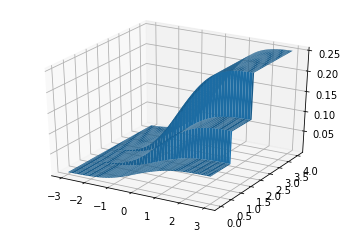

In [5]:
# plot mixture of continuous and categorical - CDF
x=np.linspace(-3,3,100)
y=np.linspace(0,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.cdf([x,x_unif_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

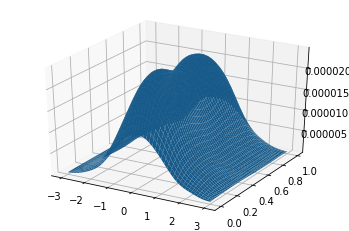

In [6]:
# plot continuous vars - PDF
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)

x_categ_samp = 2
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.pdf([x,y,x_categ_samp,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

In [7]:
# get synthetic data
df_samp = sd.get_sample(n=1000)

M = 2.1830256020476777e-05


In [8]:
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,-0.782702,0.656245,c1,2005-10-25
1,0.270965,0.349823,c2,2010-02-17
2,-0.237918,0.627400,c2,2010-11-08
3,-0.271884,0.100983,c3,2019-03-11
4,-0.600839,0.686744,c1,2013-04-06


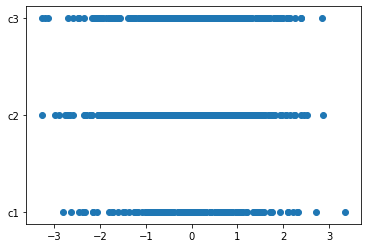

In [9]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

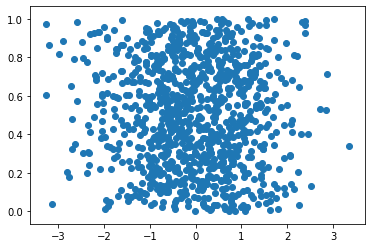

In [10]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

In [11]:
# save data to files
import json
df.to_csv('samp_dat.csv', index=False)

with open('samp_cols.json', 'w') as fid:
    json.dump(cols, fid)


# Univariate density estimation and sampling

In [12]:
from importlib import reload 
syndat = reload(syndat)

In [13]:
sd = syndat.SynDat(df, cols, convert_dt=True, independent_cols=True)

In [14]:
df_samp = sd.get_sample(n=1000)
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.417286,0.995738,c3,2012-04-15
1,-0.095636,0.503942,c3,2005-10-15
2,0.269213,0.086071,c2,2005-01-23
3,0.681559,0.148179,c2,2018-12-01
4,-0.991630,0.011034,c2,2009-12-22


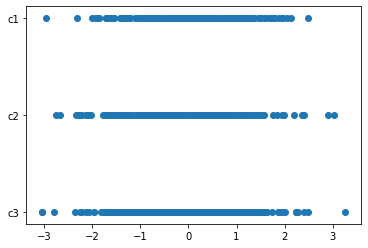

In [15]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

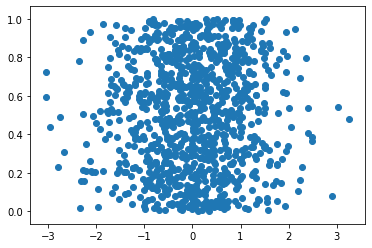

In [16]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

# Encoding categorical variables (e.g., for masking the real data)

In [17]:
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.417286,0.995738,c3,2012-04-15
1,-0.095636,0.503942,c3,2005-10-15
2,0.269213,0.086071,c2,2005-01-23
3,0.681559,0.148179,c2,2018-12-01
4,-0.991630,0.011034,c2,2009-12-22


In [18]:
import label_encoder

le_dict = {
    'categ': ['x_categ']
}

le = label_encoder.LabelEncoder(le_dict, df_samp)
df_samp = le.encode(df_samp)
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.417286,0.995738,2,2012-04-15
1,-0.095636,0.503942,2,2005-10-15
2,0.269213,0.086071,1,2005-01-23
3,0.681559,0.148179,1,2018-12-01
4,-0.991630,0.011034,1,2009-12-22
